# Bayesian Logistic Regression


In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
#ed.set_seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from edward.models import Bernoulli, Normal, Empirical
plt.style.use('ggplot')

Couldn't import dot_parser, loading of dot files will not be possible.


# Data

In [2]:
def build_toy_dataset(N, noise_std=0.1):
  D = 1
  X = np.linspace(-6, 6, num=N)
  y = np.tanh(X) + np.random.normal(0, noise_std, size=N)
  y[y < 0.5] = 0
  y[y >= 0.5] = 1
  X = (X - 4.0) / 4.0
  X = X.reshape((N, D))
  return X, y

In [3]:
N = 40  # number of data points
D = 1  # number of features

X_train, y_train = build_toy_dataset(N)
X_test, y_test = build_toy_dataset(N,4.3)

In [4]:
#X_test[:20],X_train[:20]
y_test[:10],y_train[:10]

(array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))

# Model

simple logistic regression

In [5]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=3.0 * tf.ones(D))
b = Normal(loc=tf.zeros([]), scale=3.0 * tf.ones([]))
y = Bernoulli(logits=ed.dot(X, w) + b)

## Inference

empirical variables

In [6]:
T = 5000  # number of samples
qw = Empirical(params=tf.Variable(tf.random_normal([T, D])))
qb = Empirical(params=tf.Variable(tf.random_normal([T])))

#tf.global_variables_initializer().run()

### HMC

In [7]:
inference_HMC = ed.HMC({w: qw, b: qb}, data={X: X_train, y: y_train})
inference_HMC.initialize(n_print=10, step_size=0.6)

In [8]:
inference_HMC.run(step_size=1e-3)
qw_HMC,qb_HMC=qw,qb
y_post_SGHMC = ed.copy(y, {w: qw, b: qb})
y_test=[int(i) for i in y_test]

5000/5000 [100%] ██████████████████████████████ Elapsed: 3s | Acceptance Rate: 1.000


In [9]:
inference_MH = ed.MetropolisHastings({w: qw, b: qb},{w:w,b:b},data={X: X_train, y: y_train})
#inference_MH.initialize(n_print=10, step_size=0.6)

inference_MH.run()
qw_MH,qb_MH=qw,qb

5000/5000 [100%] ██████████████████████████████ Elapsed: 2s | Acceptance Rate: 0.028


In [10]:
inference_Gibbs = ed.Gibbs({w: qw, b: qb},{w:w,b:b}, data={X: X_train, y: y_train})
#inference_Gibbs.initialize(n_print=10, step_size=0.6)
inference_Gibbs.run()
qw_Gibbs,qb_Gibbs=qw,qb

5000/5000 [100%] ██████████████████████████████ Elapsed: 8s | Acceptance Rate: 1.000


In [11]:
qw_Gibbs
#[len(i) for i in [X_test, y_post_SGHMC:y_test]]  

<ed.RandomVariable 'Empirical_2/' shape=(1,) dtype=float32>

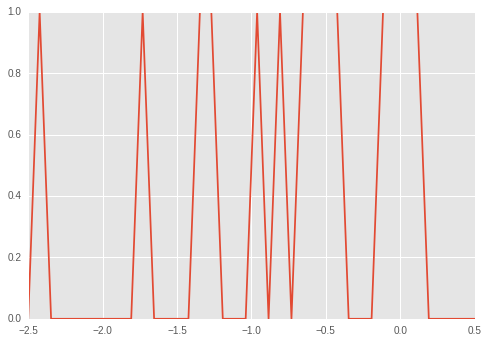

In [12]:
plt.plot(X_test,y_test)

In [13]:
y_testf=[float(i) for i in  y_test]
y_post_SGHMCf=tf.cast(y_post_SGHMC,X[0].dtype)

In [14]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post_SGHMCf: y_testf}))

Mean squared error on test data:
0.296842


In [15]:
print(ed.evaluate('binary_accuracy', data={X: X_test, y_post_SGHMC: y_test}))

0.625


In [16]:
print(ed.evaluate('categorical_accuracy', data={X: X_test, y_post_SGHMCf: y_testf}))

AttributeError: 'list' object has no attribute 'shape'

## Criticism

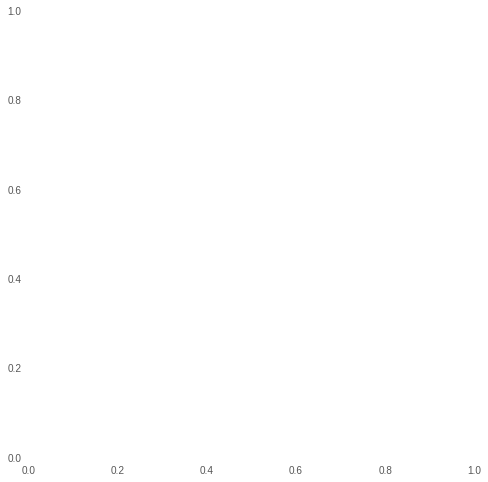

In [17]:
fig = plt.figure(figsize=(8, 8), facecolor='white')
ax = fig.add_subplot(111, frameon=False)
plt.ion()
plt.show(block=False)

## Build samples from inferred posterior
